In [197]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sp
from scipy import linalg as la
import scipy.cluster.hierarchy as hier

from sklearn.manifold import TSNE
from collections import Counter
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [80]:
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
sess.run(tf.global_variables_initializer())
y = tf.matmul(x,W) + b
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
for _ in range(1000):
  batch = mnist.train.next_batch(100)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
batch = mnist.train.next_batch(300)
labels = np.argmax(batch[1], axis=1)
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9135


Batch samples:


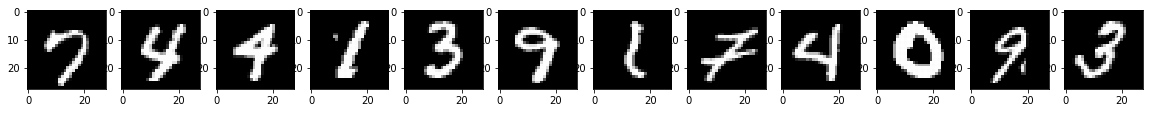

In [81]:
fig = plt.figure(figsize=(20,20)) 
imshape = (28,28)
ncols=12
nrows=1
for j in range(nrows):
    for i in range(ncols):
        imid = j*ncols+i
        imdata = np.reshape(batch[0][imid,:], imshape)
        plt.subplot(nrows,ncols,imid+1)
        plt.imshow(imdata, cmap='gray')

print('Batch samples:')
plt.show()

# Procrustes on image as a set of vectors

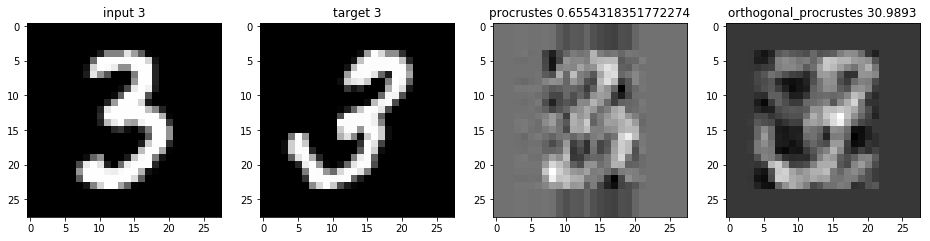

In [243]:
imid = 4
imid2= np.argmax(labels[(imid+1):]==labels[imid])+imid+1
imshape = (28,28)
imdata = np.reshape(batch[0][imid,:], imshape)
imlabel = np.argmax(batch[1][imid,:])
fig = plt.figure(figsize=(16,9)) 
#fig.suptitle(str(imlabel))

ax = plt.subplot(1,4,1)
ax.set_title('input ' + str(labels[imid]))
plt.imshow(imdata, cmap='gray')
ax = plt.subplot(1,4,2)
ax.set_title('target '  + str(labels[imid2]))
#rand_dest = np.random.rand(imshape[0], imshape[1])
rand_dest = np.reshape(batch[0][imid2,:], imshape)
plt.imshow(rand_dest, cmap='gray')

ax = plt.subplot(1,4,3)
#R = la.orthogonal_procrustes(imdata, rand_dest)
#res = np.matmul(imdata, R[0])

tres = sp.spatial.procrustes(imdata, rand_dest)
res=tres[1]
#normR = la.norm(R[0],'fro')
ax.set_title('procrustes ' + str(math.sqrt(tres[2])))
plt.imshow(res, cmap='gray')

ax = plt.subplot(1,4,4)
#R = la.orthogonal_procrustes(imdata, rand_dest)
#res = np.matmul(imdata, R[0])

R = la.orthogonal_procrustes(imdata, rand_dest)[0]
res=np.matmul(imdata, R)
#normR = la.norm(R[0],'fro')
ax.set_title('orthogonal_procrustes ' + str(np.sum(np.square(res-rand_dest))))
plt.imshow(res, cmap='gray')

plt.show()

0.8344883479328598,0.7474545141470175 explained variances


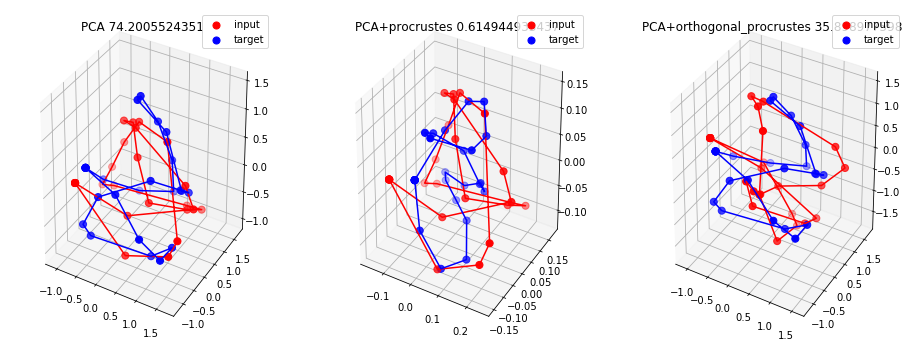

In [233]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(imdata)
X = pca.transform(imdata)
v0 = np.sum(pca.explained_variance_ratio_)

pca = PCA(n_components=3)
pca.fit(rand_dest)
Y = pca.transform(rand_dest)
v1 = np.sum(pca.explained_variance_ratio_)

x=X
y=Y
disparity = np.sum(np.square(x-y))


fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], s=50, c='r', marker='o', label='input')
ax.plot(x[:,0],x[:,1],x[:,2], c='r')
ax.scatter(y[:,0],y[:,1],y[:,2], s=50, c='b', marker='o', label='target')
ax.plot(y[:,0],y[:,1],y[:,2], c='b')
ax.legend()
ax.set_title('PCA ' + str(disparity))

x, y, disparity = sp.spatial.procrustes(x, y)
ax = fig.add_subplot(132, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], s=50, c='r', marker='o', label='input')
ax.plot(x[:,0],x[:,1],x[:,2], c='r')
ax.scatter(y[:,0],y[:,1],y[:,2], s=50, c='b', marker='o', label='target')
ax.plot(y[:,0],y[:,1],y[:,2], c='b')
ax.legend()
ax.set_title('PCA+procrustes ' +str(disparity))

R = la.orthogonal_procrustes(X, Y)[0]
x = np.matmul(X, R) 
y = Y
disparity = np.sum(np.square(x-y))
ax = fig.add_subplot(133, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], s=50, c='r', marker='o', label='input')
ax.plot(x[:,0],x[:,1],x[:,2], c='r')
ax.scatter(y[:,0],y[:,1],y[:,2], s=50, c='b', marker='o', label='target')
ax.plot(y[:,0],y[:,1],y[:,2], c='b')
ax.legend()
ax.set_title('PCA+orthogonal_procrustes ' +str(disparity))



print('{},{} explained variances'.format(v0,v1))
plt.show()


# Procrustes on vectorized image

In [7]:
def vec_procrustes(v1, v2):
    w1 = np.vstack((v1.flatten(), [0]*784))
    w2 = np.vstack((v2.flatten(), [0]*784))
    R = la.orthogonal_procrustes(w1, w2)
    return R

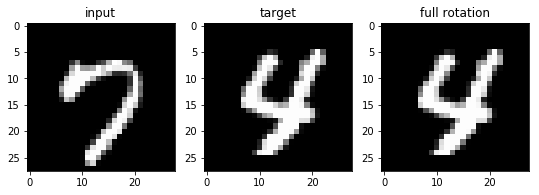

In [155]:
imid = 0
imshape = (28,28)
imdata = np.reshape(batch[0][imid,:], imshape)
imlabel = np.argmax(batch[1][imid,:])
fig = plt.figure(figsize=(9,9)) 
#fig.suptitle(str(imlabel))

ax = plt.subplot(1,3,1)
ax.set_title('input')
plt.imshow(imdata, cmap='gray')
ax = plt.subplot(1,3,2)
ax.set_title('target')
#rand_dest = np.random.rand(imshape[0], imshape[1])
rand_dest = np.reshape(batch[0][1,:], imshape)
plt.imshow(rand_dest, cmap='gray')
ax = plt.subplot(1,3,3)
ax.set_title('full rotation')
R = vec_procrustes(imdata.flatten(), rand_dest.flatten())
normR = la.norm(R[0],'fro')
plt.imshow(np.reshape(np.matmul(imdata.flatten(), R[0]), imshape), cmap='gray')

plt.show()

# MNIST procrustes clusters

In [101]:

D = np.empty([len(batch[0]),len(batch[0])])
for i in range(len(batch[0])):
    im1 = np.reshape(batch[0][i,:], imshape)
    for j in range(len(batch[0])):
        im2 = np.reshape(batch[0][j,:], imshape)
        R = la.orthogonal_procrustes(im1, im2)
        im1fit = np.matmul(im1, R[0])
        D[i,j] = la.norm(im1fit-im2, 'fro')
D = (D + D.T) / 2
np.fill_diagonal(D, 0)
print('Done computing pairwise procrustes distance')        

Done computing pairwise procrustes distance


C:\Users\shaybe\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



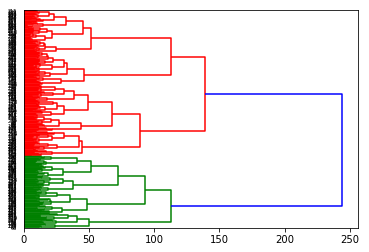

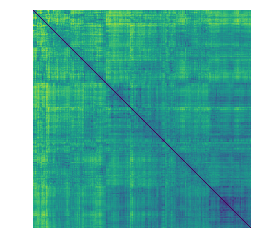

In [102]:
def compute_linkage(dists):
    Z = hier.linkage(dists, "ward")
    DG=hier.dendrogram(Z, orientation='right')
    index = DG['leaves']
    sD = D[index,:]
    sD = sD[:,index]
    fig = plt.figure()
    plt.imshow(sD)
    plt.axis('off')
    plt.show()
    return Z

Z=compute_linkage(D)

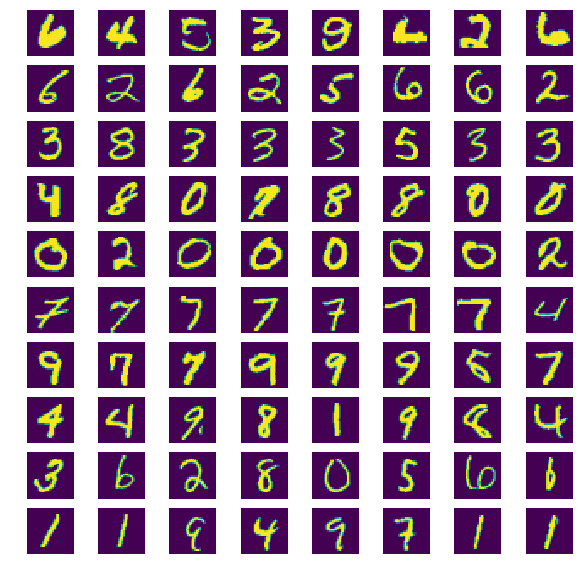

In [103]:
def show_cluster_samples(Z):
    clusts=hier.fcluster(Z, 10, criterion="maxclust")
    sizes=[len([idx for idx,c in enumerate(clusts) if c == i]) for i in range(1,11)]

    samples_per_clust=8
    tclusts=[cid+1 for cid,csize in enumerate(sizes) if csize>samples_per_clust]
    fig = plt.figure(figsize=(10,10))
    tcid=-1
    for cid in tclusts:
        tcid+=1
        samples = [idx for idx,c in enumerate(clusts) if c == cid]
        for sampleid in range(samples_per_clust):
            imid0=samples[0]
            imid=samples[sampleid+1]
            fig.add_subplot(len(tclusts),samples_per_clust,tcid*samples_per_clust + sampleid+1)
            #plt.title(str(imid))
            plt.imshow(np.reshape(batch[0][imid,:], imshape))
            plt.axis('off')
    plt.show()
show_cluster_samples(Z)

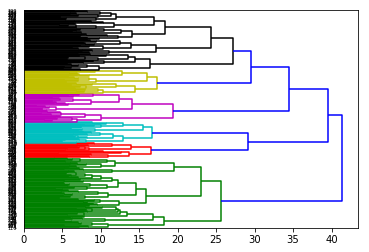

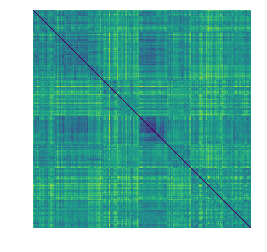

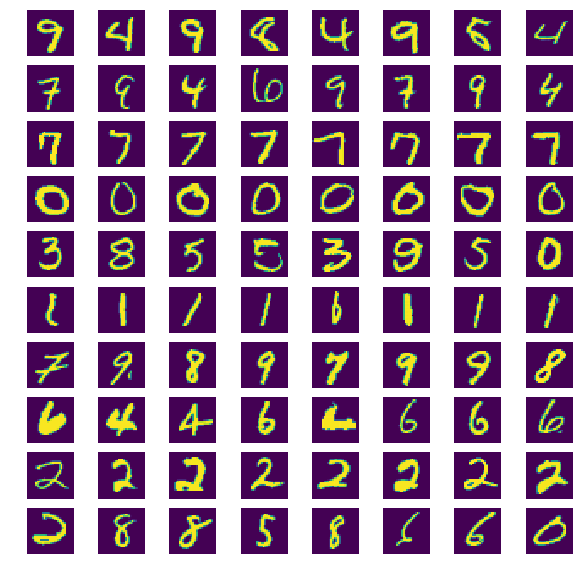

In [104]:
Dorig=sp.spatial.distance.pdist(batch[0], lambda x,y: la.norm(np.reshape(x, imshape) - np.reshape(y, imshape), 'fro'))
myZ=compute_linkage(Dorig)
show_cluster_samples(myZ)

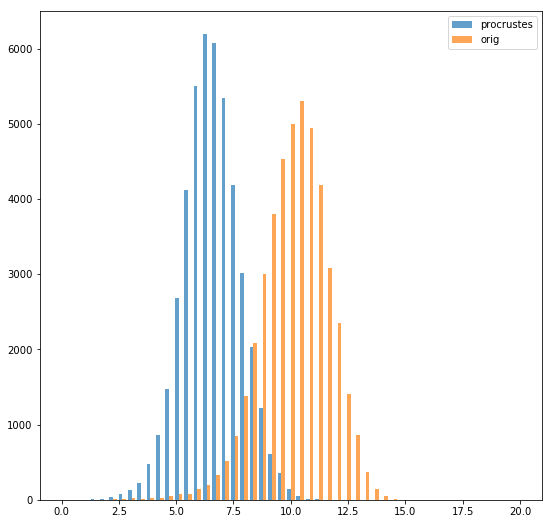

In [105]:
fig = plt.figure(figsize=(9,9)) 

tD = sp.spatial.distance.squareform(D)

data = np.vstack([tD, Dorig]).T
bins = np.linspace(0, 20, 50)
plt.hist(data, bins, alpha=0.7, label=['procrustes', 'orig'])
plt.legend(loc='upper right')
plt.show()

In [21]:
init_notebook_mode(connected=False)
model = TSNE(n_components=2, random_state=0, verbose=1, n_iter=10000, perplexity=8, metric='precomputed')
Y = model.fit_transform(D)
tY = Y.transpose()

labels = np.argmax(batch[1],axis=1)
label_counter = Counter(labels)
traces = []
for k in label_counter.keys():
    trace = go.Scatter(
        x=tY[0][labels == k],
        y=tY[1][labels == k],
        name=str(k),
        text=str(k),
        marker=dict(size=10,
                    color=k,
                    colorscale='Viridis'),
        mode='markers',
    )
    traces.append(trace)

layout = go.Layout(hovermode='closest')

fig = go.Figure(data=traces, layout=layout)
plotly.offline.iplot(fig, filename='jupyter/tsne')


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.519165
[t-SNE] KL divergence after 100 iterations with early exaggeration: 3.541301
[t-SNE] Error after 375 iterations: 3.541301
